## SAR Asymmetries

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
def wn1(thetas, a, t, phi, c):
    return a * np.cos(t * thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, np.pi / 2, initial_condition],
        bounds=([1., 0., 0., 1.], [upper_bound, np.pi, np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, t, phi, c = popt[0], popt[1], popt[2], popt[3]
    return a, t, phi, c

In [3]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/results/sar_extended/03_addIBT/dsg.nc',
    'sar_dir':  '/home/arthur/data/cyclobs/RCM/sar_files/',
    'sav_dir': '/home/arthur/results/winddirection/00_plotSARasymmetries/',
}

In [4]:
# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Open data
all_data = glob.glob(PTHS['sar_dir'] + "*.nc")
print('Nb of SAR files = {}'.format(len(all_data)))

Nb of SAR files = 816


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [19]:
# all_data = [PTHS['sar_dir'] + 'rcm1--owi-ca-20221224t125515-20221224t125759-00003-______sw_sh052023_cyclone_polar.nc']

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

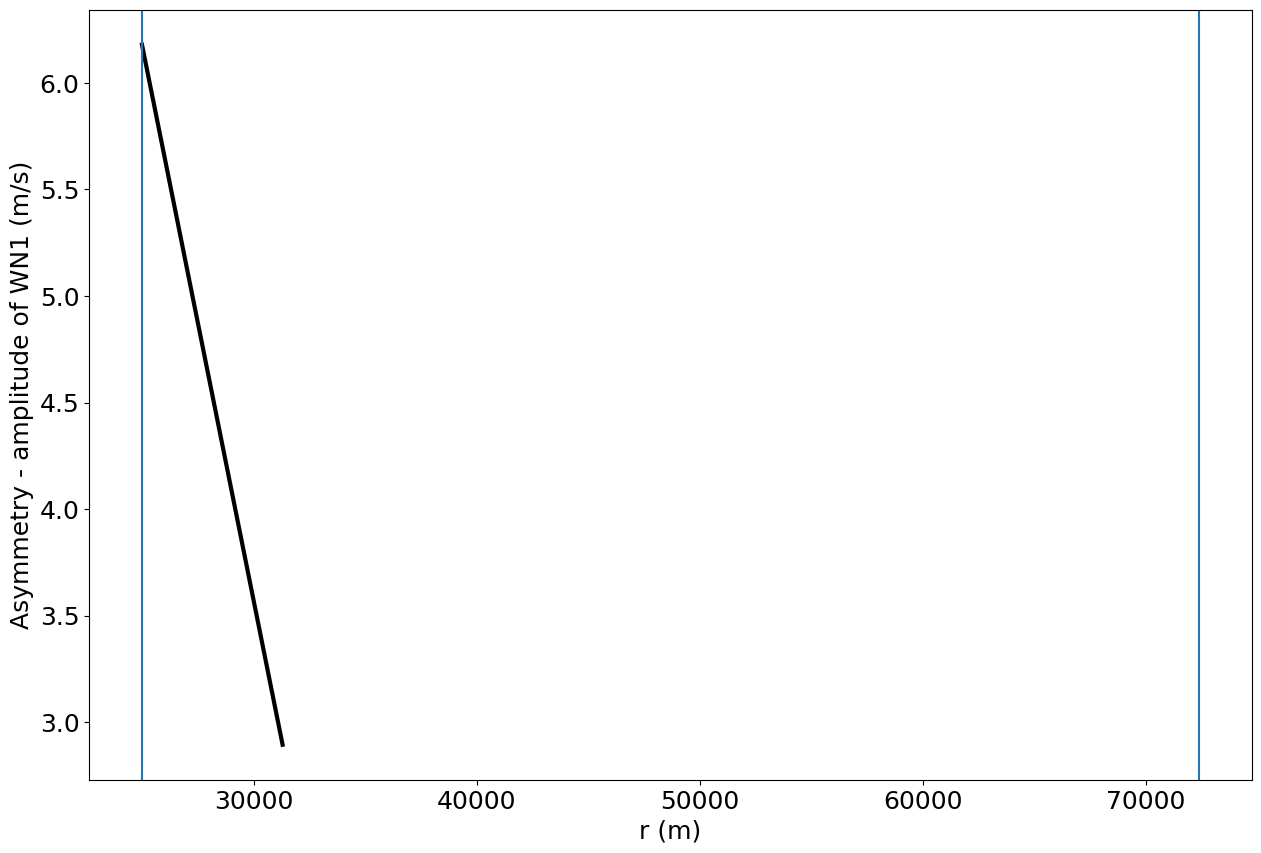

In [14]:
for file in tqdm(all_data):
    try: 
        # Open file
        dsp = xr.open_dataset(file).isel(time=0)
        ds  = dsg.where(dsg.file == dsp.attrs['Source satellite file'], drop=True).isel(time=0)
        
        if (ds.center_quality_flag < 2) & (ds.percent_outside < 50) & (abs(ds.lat) < 30) & (ds.vmx >= 33):
            # x-axis
            xs = np.linspace(ds.rmx, 2 * ds.rps, 20)

            # Asymmetries
            ASS  = []
            rads = []
            for rad in tqdm(xs):
                try:
                    # dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)).plot()
                    as_rmx, _, _, _ = get_wn1(np.deg2rad(dsp.theta), dsp.sel(rad=rad, method='nearest').wind_speed.fillna(dsp.sel(rad=rad, method='nearest').wind_speed.mean(skipna=True)), float(ds.vps), float(ds.vmx)) # SAR at Rmax
                    ASS.append(as_rmx)
                    rads.append(rad)
                except RuntimeError:
                    break

            plt.plot(rads, ASS, c='k', linewidth=3)
            plt.axvline(ds.rmx)
            plt.axvline(ds.rps)
            plt.xlabel('r (m)')
            plt.ylabel('Asymmetry - amplitude of WN1 (m/s)')

            # ### Save
            # plt.savefig(PTHS['sav_dir'] + ds.file.item().split('.')[0], bbox_inches='tight', format='png');plt.clf()

    except ValueError:
        print('Value error, file skipped.')

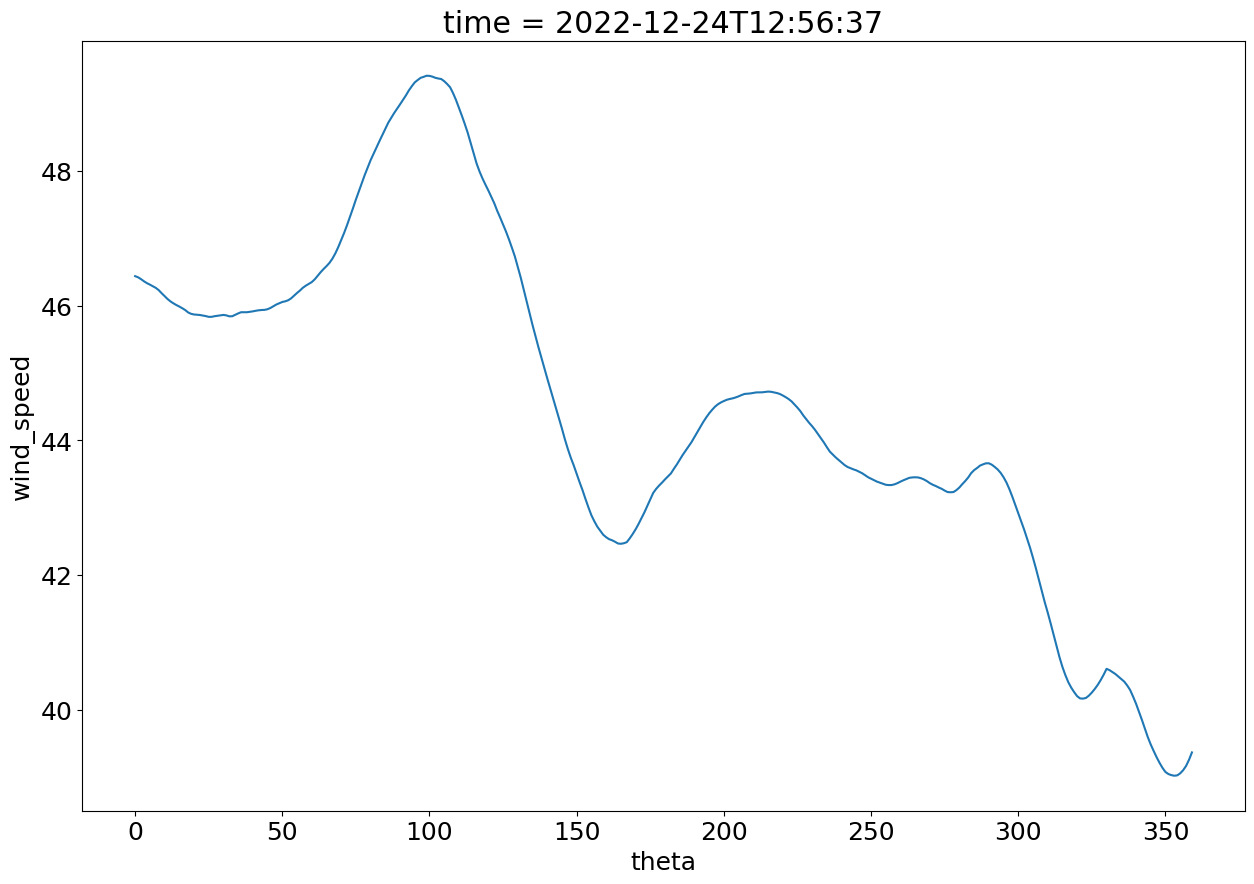

In [18]:
dsp.sel(rad=slice(rad - 3000, rad + 3000)).wind_speed.mean(dim='rad', skipna=True).rolling(theta=60, center=True, min_periods=2).mean().plot()